## Novel Stimulation Strategies Utilizing Phase Synchronization in The Virtual Brain (TVB) for Suppression of Epileptic Seizures and Pre-Seizure States

Imports

In [53]:
from tvb.simulator.lab import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from scipy.signal import hilbert
from scipy.signal import coherence
from scipy.signal import spectrogram

Loading Default Dataset

In [54]:
# Load the default connectivity data
conn = connectivity.Connectivity.from_file()

2024-08-16 21:16:24,832 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


In [74]:
# Extract region labels
region_labels = conn.region_labels

# Get the labels for the specific indices
selected_regions = region_labels[[14, 52, 11, 49]]

# Display the selected regions
print("Selected brain regions:", selected_regions)


2024-08-18 11:59:54,937 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
Selected brain regions: ['rPCIP' 'lPCIP' 'rIP' 'lIP']


Configurations

In [55]:
# Configure the spatial pattern of the stimulus (assuming 76 regions)
weighting = np.zeros((76,))  
# Choose some regions to stimulate (use multiple sites)
weighting[[14, 52, 11, 49]] = 0.1

Intialize Epileptor Model

In [56]:
# Define the Epileptor model
epileptors = models.Epileptor(Ks=np.array([-2]), r=np.array([0.0002]), tau=np.array([10]), tt=np.array([0.07]))
epileptors.x0 = -2.4*np.ones(len(conn.region_labels))
epileptors.x0[0] = -1.6  # Set one region to have a higher likelihood of seizure activity

# Set up the coupling and integrator
coupl = coupling.Difference(a=np.array([1.0]))
hiss = noise.Additive(nsig=np.array([0.001, 0.001, 0.0, 0.0001, 0.0001, 0.0]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)

Monitoring

In [72]:
# Set up the monitors
mon_tavg = monitors.TemporalAverage(period=1.0)

# Assuming you want to analyze electrodes at indices 0 and 1 (modify as needed)
variables_of_interest = np.array([0, 1])

# Set up the monitors to include the desired electrodes
mon_SEEG = monitors.iEEG.from_file(
    sensors_fname='seeg_588.txt',
    projection_fname='/Users/mac/Downloads/tvb-root/tvb_data/projectionMatrix/projection_seeg_588_surface_16k.npy',
    period=1.0,
    variables_of_interest=variables_of_interest
)

Simulation Function

In [73]:
# Run the simulation
def run_simulation(stimulus_onset, stimulus_interval):
    eqn_t = equations.PulseTrain()
    eqn_t.parameters['onset'] = stimulus_onset
    eqn_t.parameters['T'] = stimulus_interval
    eqn_t.parameters['tau'] = 50.0

    stimulus = patterns.StimuliRegion(temporal=eqn_t, connectivity=conn, weight=weighting)
    stimulus.configure_space()
    stimulus.configure_time(np.arange(0., 3e3, 2**-4))

    sim = simulator.Simulator(
        model=epileptors,
        connectivity=conn,
        coupling=coupl,
        integrator=heunint,
        monitors=[mon_tavg, mon_SEEG],
        stimulus=stimulus,
        simulation_length=5000  # 5 seconds for each simulation
    ).configure()

    (ttavg, tavg), (tseeg, seeg) = sim.run()

    # Normalize the time series for better visualization
    seeg /= (np.max(seeg, 0) - np.min(seeg, 0))
    seeg -= np.mean(seeg, 0)

    return ttavg, tavg, tseeg, seeg


Running the Stimulations (look into the bad simulator error, see if it needs to be addressed)

In [68]:
# Set up different onset times and intervals for the stimulus
stimulus_onsets = [500, 1000]  # in ms
stimulus_intervals = [50, 100]  # in ms

# Run simulations for each combination of stimulus onset and interval
results = []
for onset in stimulus_onsets:
    for interval in stimulus_intervals:
        ttavg, tavg, tseeg, seeg = run_simulation(stimulus_onset=onset, stimulus_interval=interval)
        results.append((onset, interval, ttavg, tavg, tseeg, seeg))

2024-08-18 11:04:17,243 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)


2024-08-18 11:04:17,437 - INFO - tvb.simulator.monitors - Projection configured gain shape (588, 76)
2024-08-18 11:04:30,501 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-08-18 11:04:44,050 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-08-18 11:04:57,920 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)


Comparison, FFT, and PSD

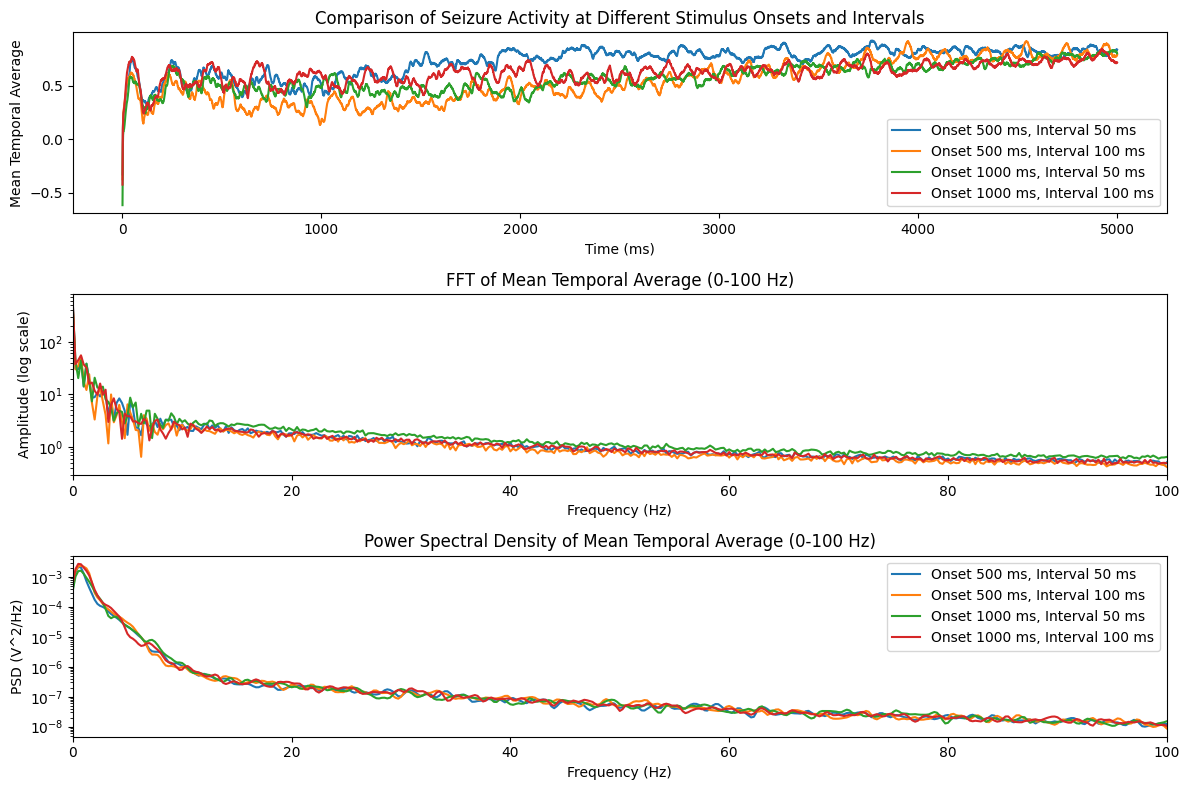

In [71]:
plt.figure(figsize=(12, 8))

for onset, interval, ttavg, tavg, tseeg, seeg in results:
    mean_temporal_avg = tavg[:, 0, :, 0].mean(axis=1)
    
    # Perform FFT with higher resolution
    nfft = 2**10  # Using 1024 points for FFT for finer frequency resolution
    fft = np.fft.fft(mean_temporal_avg, n=nfft)
    freq = np.fft.fftfreq(nfft, d=1/256)
    
    # Filter to keep only frequencies between 0 and 100 Hz
    pos_freqs = (freq >= 0) & (freq <= 100)
    pos_freqs_fft = fft[pos_freqs]
    pos_freqs_freq = freq[pos_freqs]
    
    # Calculate the PSD using Welch's method with higher resolution
    freqs, psd = welch(mean_temporal_avg, fs=256, nperseg=nfft//2, noverlap=nfft//4, nfft=nfft)
    
    # Filter the PSD frequencies to 0-100 Hz
    psd_range = freqs <= 100
    freqs = freqs[psd_range]
    psd = psd[psd_range]
    
    # Plot Mean Temporal Average
    plt.subplot(3, 1, 1)
    plt.plot(ttavg, mean_temporal_avg, label=f'Onset {onset} ms, Interval {interval} ms')
    plt.legend()
    plt.title('Comparison of Seizure Activity at Different Stimulus Onsets and Intervals')
    plt.ylabel("Mean Temporal Average")
    plt.xlabel('Time (ms)')
    
    # Plot FFT of Mean Temporal Average (0-100 Hz)
    plt.subplot(3, 1, 2)
    plt.plot(pos_freqs_freq, np.abs(pos_freqs_fft), label=f'Onset {onset} ms, Interval {interval} ms')
    plt.yscale('log')  # Use logarithmic scale for amplitude
    plt.xlim(0, 100)
    plt.title('FFT of Mean Temporal Average (0-100 Hz)')
    plt.ylabel('Amplitude (log scale)')
    plt.xlabel('Frequency (Hz)')

    
    
    # Plot PSD of Mean Temporal Average (0-100 Hz)
    plt.subplot(3, 1, 3)
    plt.semilogy(freqs, psd, label=f'Onset {onset} ms, Interval {interval} ms')
    plt.legend()
    plt.title('Power Spectral Density of Mean Temporal Average (0-100 Hz)')
    plt.xlim(0, 100)
    plt.ylabel('PSD (V^2/Hz)')
    plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


Attempt one at evaluating phase synchronization

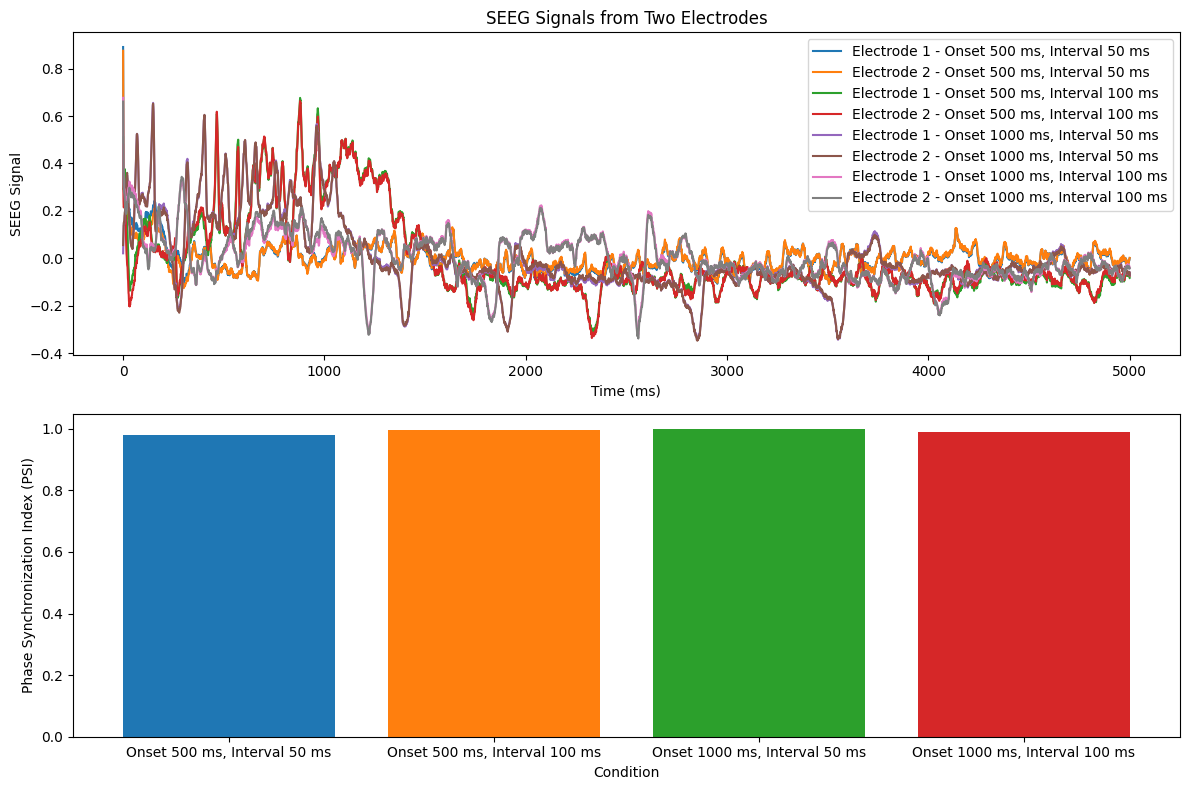

In [61]:
# Function to calculate phase synchronization
def calculate_phase_synchronization(signal1, signal2):
    # Calculate the analytic signal (Hilbert transform) for each signal
    analytic_signal1 = hilbert(signal1)
    analytic_signal2 = hilbert(signal2)
    
    # Extract the instantaneous phase
    phase1 = np.angle(analytic_signal1)
    phase2 = np.angle(analytic_signal2)
    
    # Calculate phase difference
    phase_diff = np.abs(phase1 - phase2)
    
    # Calculate phase synchronization index (PSI)
    psi = np.abs(np.mean(np.exp(1j * phase_diff)))
    
    return psi


# Plot results and calculate phase synchronization
plt.figure(figsize=(12, 8))
for onset, interval, ttavg, tavg, tseeg, seeg in results:
    electrode1_signal = seeg[:, 0, 0, 0]  # First electrode
    electrode2_signal = seeg[:, 0, 1, 0]  # Second electrode
    
    # Plot the signals
    plt.subplot(2, 1, 1)
    plt.plot(ttavg, electrode1_signal, label=f'Electrode 1 - Onset {onset} ms, Interval {interval} ms')
    plt.plot(ttavg, electrode2_signal, label=f'Electrode 2 - Onset {onset} ms, Interval {interval} ms')
    plt.legend()
    plt.title('SEEG Signals from Two Electrodes')
    plt.ylabel("SEEG Signal")
    plt.xlabel('Time (ms)')
    
    # Calculate and plot phase synchronization
    psi = calculate_phase_synchronization(electrode1_signal, electrode2_signal)
    plt.subplot(2, 1, 2)
    plt.bar(f'Onset {onset} ms, Interval {interval} ms', psi)
    plt.ylabel('Phase Synchronization Index (PSI)')
    plt.xlabel('Condition')

plt.tight_layout()
plt.show()



Attempt two at evaluating phase synchronization

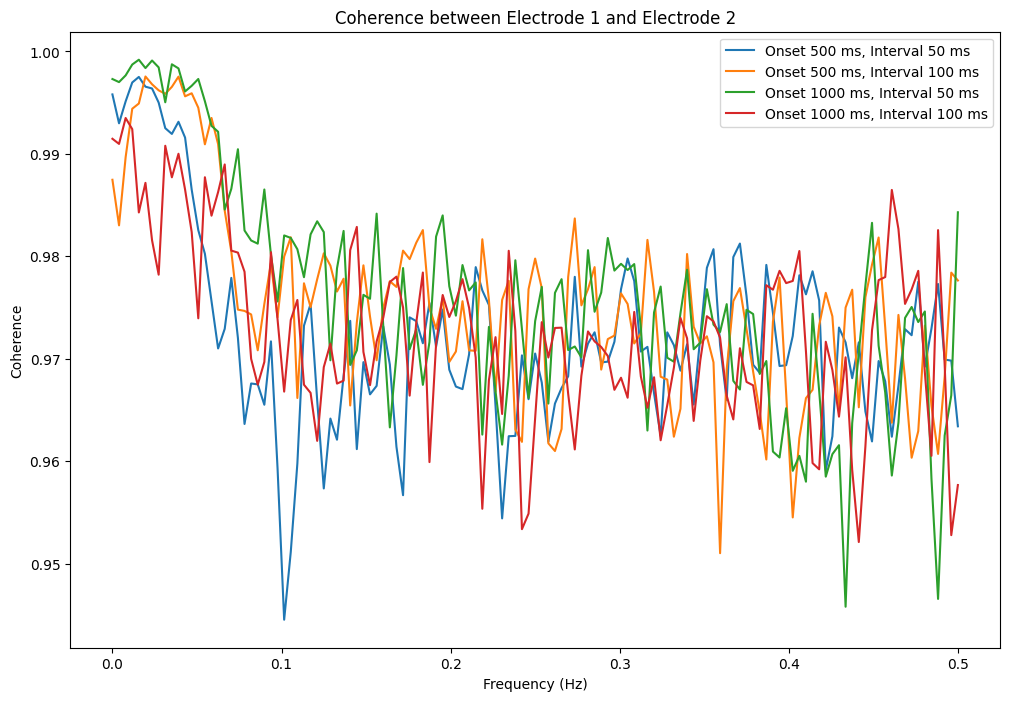

In [62]:

plt.figure(figsize=(12, 8))
for onset, interval, ttavg, tavg, tseeg, seeg in results:
    # Compute coherence between the two electrodes
    f, Cxy = coherence(seeg[:, 0, 0, 0], seeg[:, 0, 1, 0], fs=1/(ttavg[1] - ttavg[0]), nperseg=256)
    
    plt.plot(f, Cxy, label=f'Onset {onset} ms, Interval {interval} ms')

plt.title('Coherence between Electrode 1 and Electrode 2')
plt.ylabel('Coherence')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()


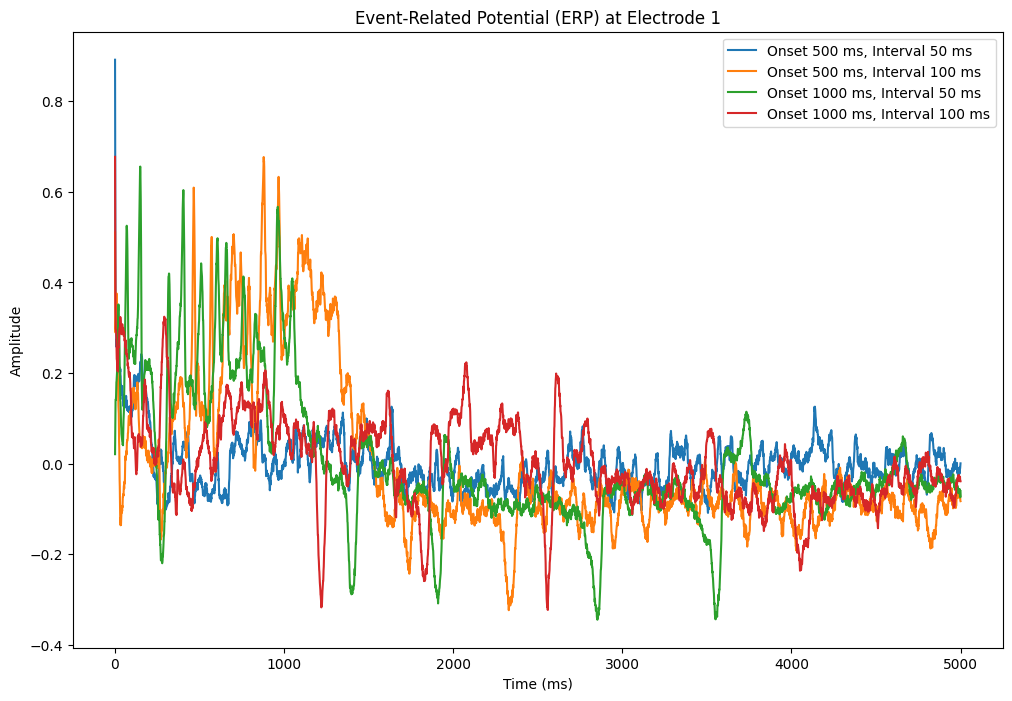

In [63]:
plt.figure(figsize=(12, 8))
for onset, interval, ttavg, tavg, tseeg, seeg in results:
    # Compute ERP for electrode 1 by averaging across all time points
    erp = np.mean(seeg[:, 0, 0, :], axis=1)

    plt.plot(ttavg, erp, label=f'Onset {onset} ms, Interval {interval} ms')

plt.title('Event-Related Potential (ERP) at Electrode 1')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()


plt.figure(figsize=(12, 10))
for onset, interval, ttavg, tavg, tseeg, seeg in results:
    # Reshape the SEEG data to have shape (time, electrodes)
    reshaped_seeg = seeg[:, 0, :, 0]
    
    # Compute the correlation matrix
    corr_matrix = np.corrcoef(reshaped_seeg.T)
    
    # Plot the correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu', xticklabels=variables_of_interest, yticklabels=variables_of_interest, vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix - Onset {onset} ms, Interval {interval} ms')
    plt.show()

from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Loop through each simulation result
for onset, interval, ttavg, tavg, tseeg, seeg in results:
    # Create a new figure for each condition
    plt.figure(figsize=(12, 8))
    
    # Compute spectrogram for the first electrode
    f, t, Sxx = spectrogram(seeg[:, 0, 0, 0], fs=1/(ttavg[1] - ttavg[0]), nperseg=256, noverlap=128)

    plt.subplot(2, 1, 1)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Power (dB)')
    plt.title(f'Spectrogram - Electrode 1 - Onset {onset} ms, Interval {interval} ms')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')

    # Compute spectrogram for the second electrode
    f, t, Sxx = spectrogram(seeg[:, 0, 1, 0], fs=1/(ttavg[1] - ttavg[0]), nperseg=256, noverlap=128)
    
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Power (dB)')
    plt.title(f'Spectrogram - Electrode 2 - Onset {onset} ms, Interval {interval} ms')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')

    plt.tight_layout()
    plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

plt.figure(figsize=(12, 8))

for onset, interval, ttavg, tavg, tseeg, seeg in results:
    mean_temporal_avg = tavg[:, 0, :, 0].mean(axis=1)

    # Define the sampling frequency
    fs = 256 # Sampling frequency from time vector

    # Calculate PSD using Welch's method
    freqs, psd = welch(mean_temporal_avg, fs=fs, nperseg=len(mean_temporal_avg)//8, noverlap=len(mean_temporal_avg)//16)
    
    # Filter PSD frequencies to 0-100 Hz
    psd_range = freqs <= 100
    freqs = freqs[psd_range]
    psd = psd[psd_range]
    
    # Plot Mean Temporal Average
    plt.subplot(3, 1, 1)
    plt.plot(ttavg, mean_temporal_avg, label=f'Onset {onset} ms, Interval {interval} ms')
    plt.legend()
    plt.title('Comparison of Seizure Activity at Different Stimulus Onsets and Intervals')
    plt.ylabel("Mean Temporal Average")
    plt.xlabel('Time (ms)')
    
    # Plot PSD using Welch's method
    plt.subplot(3, 1, 2)
    plt.semilogy(freqs, psd, label=f'Onset {onset} ms, Interval {interval} ms')
    plt.legend()
    plt.title('Power Spectral Density of Mean Temporal Average (0-100 Hz)')
    plt.ylabel('PSD (V^2/Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.xlim(0, 100)

plt.tight_layout()
plt.show()
